## naive bayes

## target rating con tutte le features (anche sintetiche)

In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    #df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    #df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df


def engineer_rankCluster(df):
    # 1. Selezione feature
    X = df[["NumOwned", "NumWant", "GameWeight", "PlaytimeRange"]]

    # 2. Standardizzazione
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df["Cluster"] = kmeans.fit_predict(X_scaled)

    # 4. Ordina cluster per popolarità media
    cluster_order = df.groupby("Cluster")["NumOwned"].mean().sort_values(ascending=False).index

    # 5. Mappa cluster → rank
    mapping = {cluster: rank+1 for rank, cluster in enumerate(cluster_order)}
    df["RankArtificial"] = df["Cluster"].map(mapping)

    return df

def engineer_artificial_score(df, weights=None, features=None, ascending=False):
    """
    Artificial Score & RankScore based on a weighted linear combination of features.

    Parametri:
    - df: DataFrame dei giochi
    - weights: dict feature -> peso
               Se None, usa pesi di default
    - features: lista delle feature da usare.
                Se None usa le key di weights
    - ascending: True → rank basso = migliore,
                 False → rank alto = migliore

    Output:
    - df con colonne:
        • Score
        • RankScore
    """

    # 1. Default weights
    if weights is None:
        weights = {
            "NumOwned": 0.4,
            "NumWant": 0.2,
            "NumWeightVotes": 0.2,
            "GameWeight": 0.1,
            "PlaytimeRange": -0.1
        }

    # 2. Default feature list
    if features is None:
        features = list(weights.keys())

    # 3. Compute weighted score
    df["Score"] = sum(df[f] * weights[f] for f in features)

    # 4. Rank computed score
    df["RankScore"] = df["Score"].rank(ascending=ascending)

    return df



def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    df = engineer_rankCluster(df)
    df = engineer_artificial_score(df)
    return df

In [ ]:
df = apply_all_feature_engineering(df)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# FEATURES e TARGET
features = [
        'YearPublished','GameWeight','MinPlayers','MaxPlayers','ComAgeRec','LanguageEase_log',
        'NumOwned','NumWant','NumWeightVotes','ComMinPlaytime','ComMaxPlaytime','MfgAgeRec',
        'NumAlternates','NumExpansions','NumImplementations',

        # Engineered
        #'AvgRank','RankSpread',
        'RangePlayers','IsSoloPlayable','IsPartySize',
        'PlaytimeRange','DemandRatio','OwnershipRatio',
        'NumCategories','BestRank',

        # Categories multi-label already binary
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens',

        # Binary or ordinal categorical BUT encoded as numeric
        'BestPlayers',         # ordinal
        'Kickstarted',         # binary
        'IsReimplementation',   # binary

        # Cluster-based artificial rank
        'RankArtificial',

        # Artificial score and rank
        'Score',      # ⬅️ nuova feature
        'RankScore'

    ]

target = ['Rating']   # categorica: Low, Medium, High

X = df[features].copy()
y = df[target].copy()

In [ ]:
# Serve convertire y in un vettore 1D
y = y.values.ravel()

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()


In [ ]:
# Addestramento
model_nb.fit(X_train, y_train)


GaussianNB()

In [ ]:
# Predizione
y_pred = model_nb.predict(X_test)

# Valutazione
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5252356339312861
              precision    recall  f1-score   support

        High       0.62      0.40      0.49      1555
         Low       0.48      0.89      0.63      2114
      Medium       0.56      0.33      0.41      2909

    accuracy                           0.53      6578
   macro avg       0.56      0.54      0.51      6578
weighted avg       0.55      0.53      0.50      6578



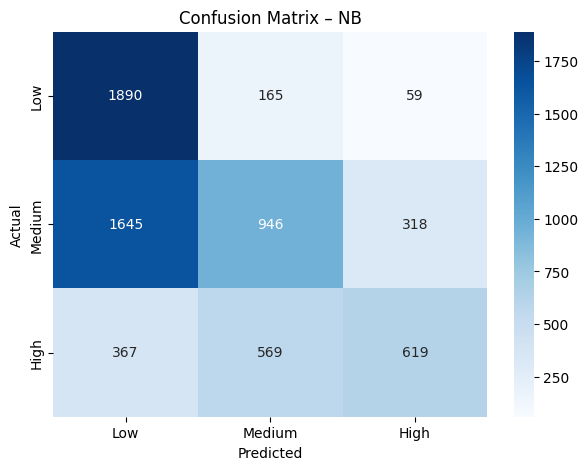

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Calcola la confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])


# 2. Crea la figura

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – NB')
plt.show()


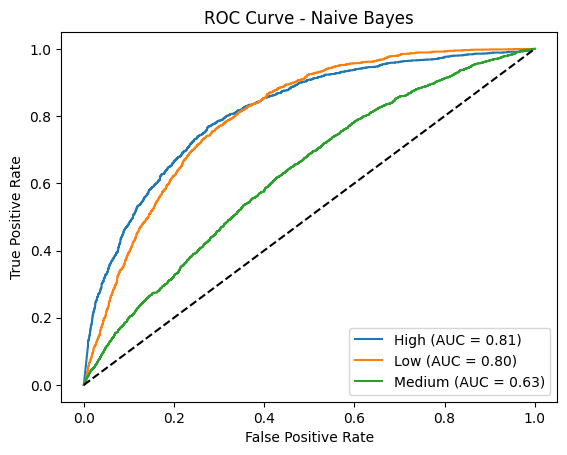

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Binarizzazione classi
classes = model_nb.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilità previste
y_score = model_nb.predict_proba(X_test)

plt.figure()

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_nb, X, y, cv=10)

print("Cross-Validation Accuracy scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Std Dev:", scores.std())


Cross-Validation Accuracy scores: [0.53169175 0.53625171 0.53169175 0.52211582 0.52713178 0.53056569
 0.5314781  0.53968978 0.51824818 0.51687956]
Mean Accuracy: 0.5285744122806142
Std Dev: 0.007081805783023231


## target rating dopo sintetiche

In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df

def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    return df

In [ ]:
df = apply_all_feature_engineering(df)

In [ ]:

df.columns.to_list()

['BGGId',
 'Name',
 'Description',
 'YearPublished',
 'GameWeight',
 'MinPlayers',
 'MaxPlayers',
 'ComAgeRec',
 'LanguageEase',
 'BestPlayers',
 'GoodPlayers',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'ComMinPlaytime',
 'ComMaxPlaytime',
 'MfgAgeRec',
 'NumAlternates',
 'NumExpansions',
 'NumImplementations',
 'IsReimplementation',
 'Kickstarted',
 'Rank:strategygames',
 'Rank:abstracts',
 'Rank:familygames',
 'Rank:thematic',
 'Rank:cgs',
 'Rank:wargames',
 'Rank:partygames',
 'Rank:childrensgames',
 'Cat:Thematic',
 'Cat:Strategy',
 'Cat:War',
 'Cat:Family',
 'Cat:CGS',
 'Cat:Abstract',
 'Cat:Party',
 'Cat:Childrens',
 'Rating',
 'LanguageEase_log',
 'RangePlayers',
 'IsSoloPlayable',
 'IsPartySize',
 'PlaytimeRange',
 'DemandRatio',
 'OwnershipRatio',
 'NumCategories',
 'BestRank',
 'AvgRank',
 'RankSpread']

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Added MinMaxScaler to imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

df_knn = df.copy()

#Trasformazione target Rating in numerico
rating_map = {'Low': 1, 'Medium': 2, 'High': 3}
df_knn['Rating_num'] = df_knn['Rating'].map(rating_map)
y = df_knn['Rating_num'].values  # target numerico

# Selezione feature numeriche (esclude target)
numeric_cols = df_knn.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Rating_num' in numeric_cols:
    numeric_cols.remove('Rating_num')
X = df_knn[numeric_cols]

# Handle NaN values by imputing with the mean
X = X.fillna(X.mean())

# Selezione migliori feature con SelectKBest
k = 10  # numero di feature migliori
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Feature selezionate:", selected_features.tolist())
print("Punteggi di tutte le feature:")
for f, s in zip(X.columns, selector.scores_):
    print(f"{f}: {s:.2f}")



Feature selezionate: ['BGGId', 'GameWeight', 'ComAgeRec', 'BestPlayers', 'NumWant', 'ComMaxPlaytime', 'Rank:wargames', 'IsSoloPlayable', 'PlaytimeRange', 'OwnershipRatio']
Punteggi di tutte le feature:
BGGId: 2084.05
YearPublished: 67.13
GameWeight: 2789.98
MinPlayers: 415.56
MaxPlayers: 322.31
ComAgeRec: 898.55
LanguageEase: 30.20
BestPlayers: 662.14
NumOwned: 463.24
NumWant: 1780.91
NumWeightVotes: 285.40
ComMinPlaytime: 495.68
ComMaxPlaytime: 1253.94
MfgAgeRec: 352.74
NumAlternates: 22.50
NumExpansions: 268.26
NumImplementations: 100.07
IsReimplementation: 204.72
Kickstarted: 458.46
Rank:strategygames: 644.11
Rank:abstracts: 351.71
Rank:familygames: 579.85
Rank:thematic: 364.34
Rank:cgs: 111.22
Rank:wargames: 998.94
Rank:partygames: 201.39
Rank:childrensgames: 234.08
Cat:Thematic: 80.13
Cat:Strategy: 518.89
Cat:War: 402.67
Cat:Family: 99.62
Cat:CGS: 1.94
Cat:Abstract: 40.83
Cat:Party: 27.48
Cat:Childrens: 354.23
LanguageEase_log: 59.41
RangePlayers: 152.43
IsSoloPlayable: 673.50
IsP

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# FEATURES e TARGET
features = ['GameWeight', 'ComAgeRec', 'BestPlayers', 'NumWant', 'ComMaxPlaytime', 'PlaytimeRange', 'OwnershipRatio']
target = ['Rating']   # categorica: Low, Medium, High

X = df_knn[features].copy()
y = df_knn[target].copy()

In [ ]:
# Serve convertire y in un vettore 1D
y = y.values.ravel()

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()


In [ ]:
# Addestramento
model_nb.fit(X_train, y_train)


GaussianNB()

In [ ]:
# Predizione
y_pred = model_nb.predict(X_test)

# Valutazione
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5241714806932198
              precision    recall  f1-score   support

        High       0.61      0.46      0.52      1555
         Low       0.48      0.92      0.63      2114
      Medium       0.59      0.28      0.38      2909

    accuracy                           0.52      6578
   macro avg       0.56      0.55      0.51      6578
weighted avg       0.56      0.52      0.49      6578



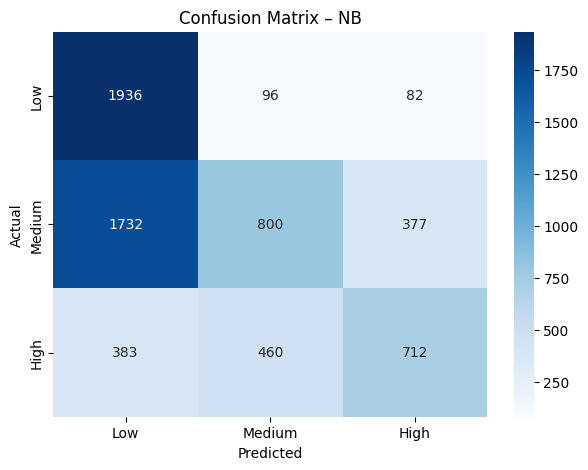

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Calcola la confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])


# 2. Crea la figura

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – NB')
plt.show()


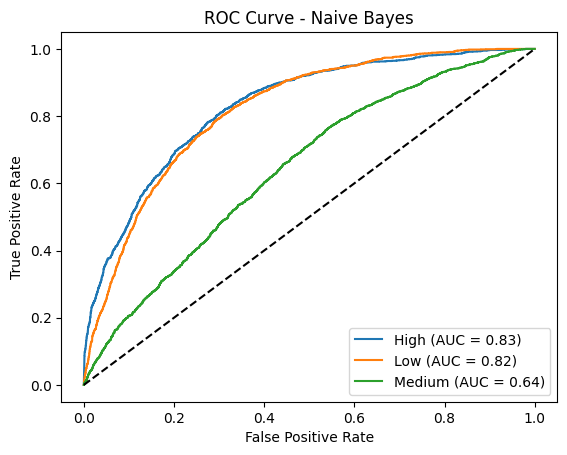

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Binarizzazione classi
classes = model_nb.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilità previste
y_score = model_nb.predict_proba(X_test)

plt.figure()

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_nb, X, y, cv=10)

print("Cross-Validation Accuracy scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Std Dev:", scores.std())


Cross-Validation Accuracy scores: [0.52576379 0.53488372 0.52713178 0.52257182 0.51755586 0.52600365
 0.52600365 0.52874088 0.52874088 0.51916058]
Mean Accuracy: 0.5256556611780683
Std Dev: 0.0047321232171030425


## target rating

In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')

In [ ]:
df_knn = df.copy()
df_knn.columns.to_list()

['BGGId',
 'Name',
 'Description',
 'YearPublished',
 'GameWeight',
 'MinPlayers',
 'MaxPlayers',
 'ComAgeRec',
 'LanguageEase',
 'BestPlayers',
 'GoodPlayers',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'ComMinPlaytime',
 'ComMaxPlaytime',
 'MfgAgeRec',
 'NumAlternates',
 'NumExpansions',
 'NumImplementations',
 'IsReimplementation',
 'Kickstarted',
 'Rank:strategygames',
 'Rank:abstracts',
 'Rank:familygames',
 'Rank:thematic',
 'Rank:cgs',
 'Rank:wargames',
 'Rank:partygames',
 'Rank:childrensgames',
 'Cat:Thematic',
 'Cat:Strategy',
 'Cat:War',
 'Cat:Family',
 'Cat:CGS',
 'Cat:Abstract',
 'Cat:Party',
 'Cat:Childrens',
 'Rating',
 'LanguageEase_log']

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# FEATURES e TARGET
features = ['GameWeight', 'ComAgeRec', 'NumWant', 'ComMaxPlaytime']
target = ['Rating']   # categorica: Low, Medium, High

X = df_knn[features].copy()
y = df_knn[target].copy()

In [ ]:
# Serve convertire y in un vettore 1D
y = y.values.ravel()

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()


In [ ]:
# Addestramento
model_nb.fit(X_train, y_train)


GaussianNB()

In [ ]:
# Predizione
y_pred = model_nb.predict(X_test)

# Valutazione
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.540589844937671
              precision    recall  f1-score   support

        High       0.65      0.42      0.51      1555
         Low       0.49      0.88      0.63      2114
      Medium       0.58      0.35      0.44      2909

    accuracy                           0.54      6578
   macro avg       0.57      0.55      0.53      6578
weighted avg       0.57      0.54      0.52      6578



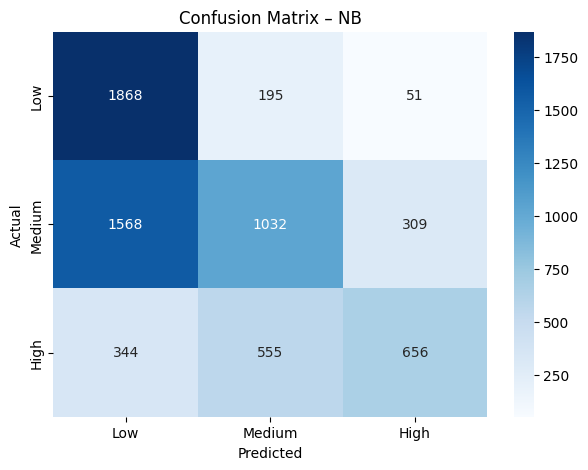

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Calcola la confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])


# 2. Crea la figura

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – NB')
plt.show()


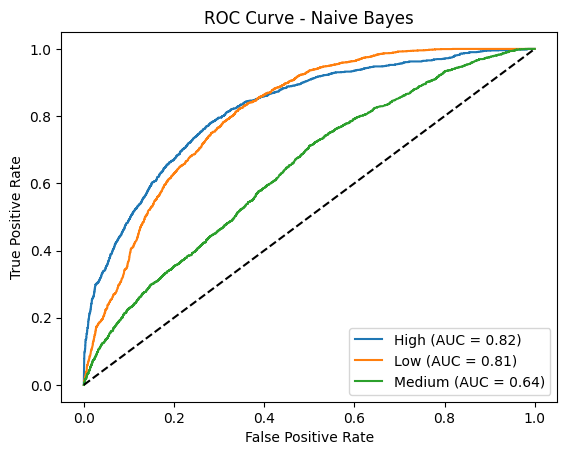

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Binarizzazione classi
classes = model_nb.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilità previste
y_score = model_nb.predict_proba(X_test)

plt.figure()

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_nb, X, y, cv=10)

print("Cross-Validation Accuracy scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Std Dev:", scores.std())


Cross-Validation Accuracy scores: [0.54172367 0.54445964 0.55221158 0.54810762 0.54719562 0.53923358
 0.54562044 0.55109489 0.53968978 0.52919708]
Mean Accuracy: 0.5438533896838316
Std Dev: 0.006427123097642062
